In [22]:
import sys
import importlib
import pickle

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# pytorch specific
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import visualisation
from models import torch_AE

pd.options.display.width = 1000

### Load Dataset

In [23]:
with open('../workfiles/BRCA_ds.pkl', 'rb') as f:
    data, metadata = pickle.load(f)

In [24]:
dat = data
print(dat.shape)
feature_num = dat.shape[1]
dat = dat.reshape(-1,1,feature_num)
print(dat.shape)
label = metadata["PAM50_labels"]
feature_num = metadata["n_features"]

(1231, 10277)
(1231, 1, 10277)


In [25]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [26]:
batch_size = 16 # was 32 originally

train_data, test_data = train_test_split(dat, test_size = 0.1, random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = batch_size, shuffle=True)

train data: 1107
test data: 124


### Generate model

In [27]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For m1 Mac
DEVICE = torch.device("mps")

In [66]:
importlib.reload(torch_AE)

latent_dim = 64
model = torch_AE.Autoencoder(
    shape = feature_num,
    dropout = 0.2,
    latent_dim = latent_dim,
    is_variational = True
    ).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=False)

print(DEVICE)

mps


#### Train Model

In [67]:
train_res_recon_error = []
perplexities = []
frames = []
n_frames = 0

0.0001


 10%|▉         | 99/1000 [04:12<25:53,  1.72s/it]  

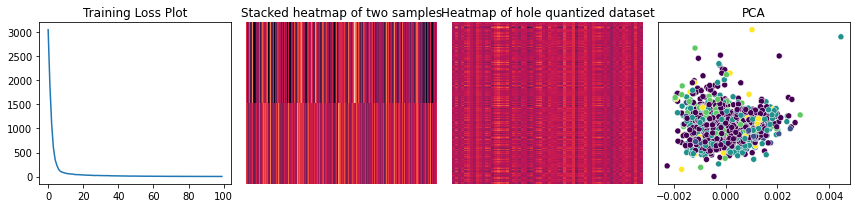

 20%|█▉        | 199/1000 [08:28<22:32,  1.69s/it]  

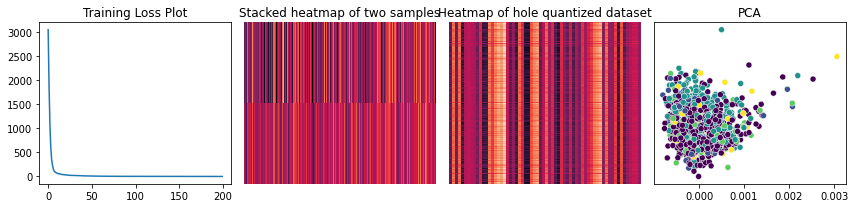

 30%|██▉       | 299/1000 [12:57<21:25,  1.83s/it]  

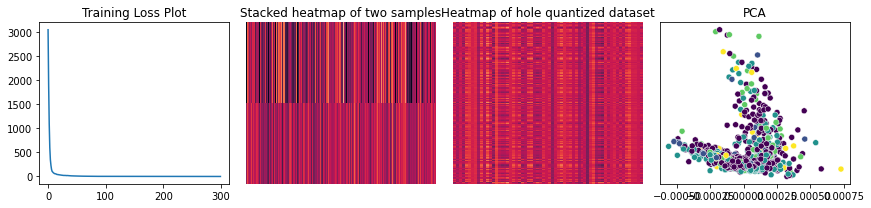

 40%|███▉      | 399/1000 [17:54<18:15,  1.82s/it]  

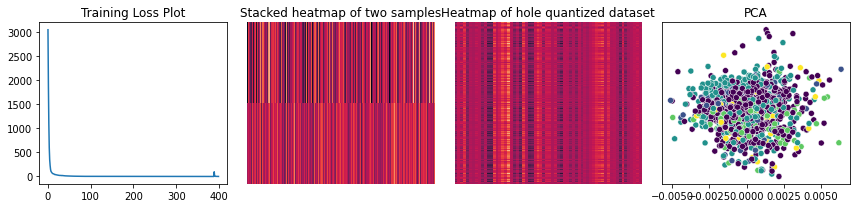

 50%|████▉     | 499/1000 [22:56<14:33,  1.74s/it]  

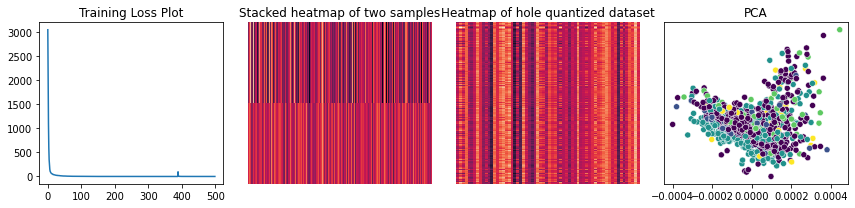

 60%|█████▉    | 599/1000 [28:04<11:25,  1.71s/it]

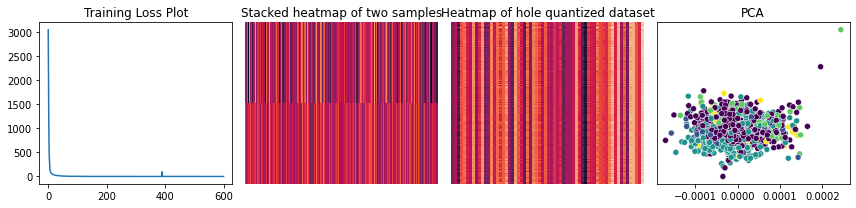

 70%|██████▉   | 699/1000 [33:04<08:36,  1.71s/it]

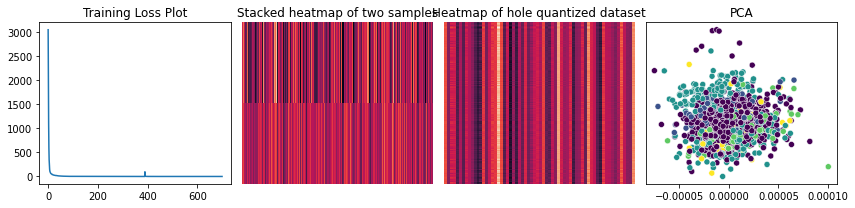

 80%|███████▉  | 799/1000 [38:10<05:42,  1.71s/it]

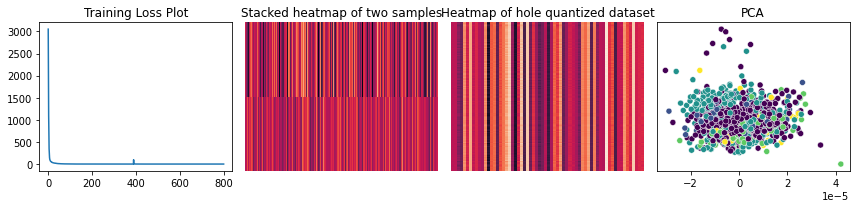

 90%|████████▉ | 899/1000 [43:11<02:54,  1.73s/it]

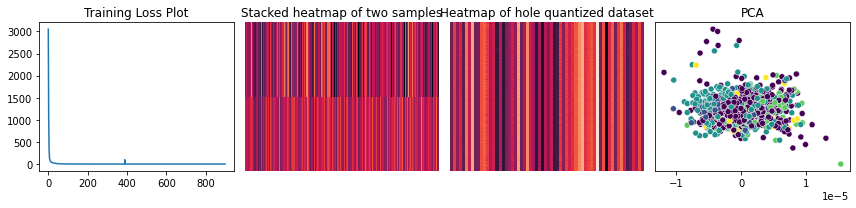

100%|█████████▉| 999/1000 [48:15<00:01,  1.71s/it]

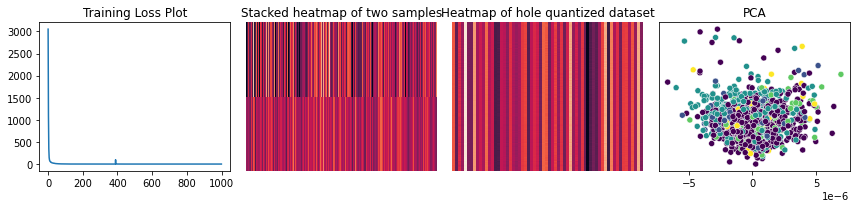

100%|██████████| 1000/1000 [48:32<00:00,  2.91s/it]

0.0001


In [68]:
EPOCH = 1000

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr= 0.000001)
print(optimizer.param_groups[0]['lr'])


for epoch in tqdm(range(EPOCH)):
    model.train()

    running_loss = 0.0
    count = 0
    
    # Training loop
    for _, inputs in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)        
        
        # Compute the VAE loss or standard loss
        if model.is_variational:
            outputs, mu, log_var = model(inputs)
            reconstruction_loss = F.mse_loss(outputs, inputs)
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconstruction_loss + 500 *kld
        else:
            outputs = model(inputs)
            loss = F.mse_loss(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    train_res_recon_error.append(train_loss)


    if (epoch + 1) % 10 == 0:
        en_lat = []
        en_reconstruction = []

        model.eval()

        data_set = Mydatasets(data1 = dat)
        data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 


        for i in range(len(dat)):
            en_data = data_set.dataset[i][0]

            if model.is_variational:
                latent_1, _ = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
                data_recon, _, _ = model(en_data.view(1, 1, feature_num).float().to(DEVICE))


            else:
                latent_1 = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
                data_recon = model(en_data.view(1, 1, feature_num).float().to(DEVICE))

            

            en_lat.append(latent_1.cpu().detach().numpy())
            en_reconstruction.append(data_recon.cpu().detach().numpy())

        encode_out = np.array(en_lat).reshape(len(dat), -1)
        reconstruction_out = np.array(en_reconstruction).reshape(len(dat), -1)


        
        # PCA of the latent space
        pca = PCA(n_components=2)
        pca.fit(encode_out)
        pca_result = pca.transform(encode_out)

        index_column = np.full((pca_result.shape[0], 1), n_frames, dtype=int)

        pca_result_with_index = np.hstack((index_column, pca_result))

        frames.append(pca_result_with_index)
        n_frames += 1

        if (epoch + 1) % 100 == 0:

            # stacking a single observation as well as its reconstruction in order to evaluate the results
            stack = np.vstack([dat[0].reshape(1, -1), reconstruction_out[0].reshape(1, -1)])

            # prepping a 1x4 plot to monitor the model through training
            fig, axs = plt.subplots(1, 4, figsize=(12, 3))


            # Plot the line plot in the second subplot
            axs[0].plot(train_res_recon_error, label='Training Loss')
            axs[0].set_title('Training Loss Plot')
            #axs[0].set_xticks([])

            sns.heatmap(stack, ax=axs[1], cbar=False)
            axs[1].set_title('Stacked heatmap of two samples')
            axs[1].set_xticks([])
            axs[1].set_yticks([])


            sns.heatmap(encode_out, ax = axs[2], cbar=False)
            axs[2].set_title('Heatmap of hole quantized dataset')
            axs[2].set_xticks([])
            axs[2].set_yticks([])


            sns.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], c=label, ax=axs[3])
            axs[3].set_title('PCA')
            #axs[3].set_xticks([])
            axs[3].set_yticks([])

            plt.subplots_adjust(wspace=0)  
            plt.tight_layout()
            plt.show()


print(optimizer.param_groups[0]['lr'])


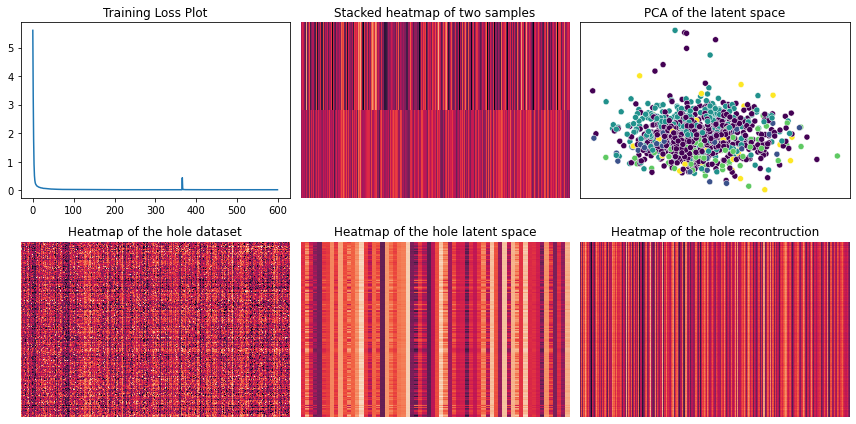

In [50]:
en_lat = []
en_reconstruction = []

model.eval()

data_set = Mydatasets(data1 = dat)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 


for i in range(len(dat)):
    en_data = data_set.dataset[i][0]

    if model.is_variational:
        latent_1, _ = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
        data_recon, _, _ = model(en_data.view(1, 1, feature_num).float().to(DEVICE))


    else:
        latent_1 = model.encode(en_data.view(1, 1, feature_num).float().to(DEVICE))
        data_recon = model(en_data.view(1, 1, feature_num).float().to(DEVICE))

    

    en_lat.append(latent_1.cpu().detach().numpy())
    en_reconstruction.append(data_recon.cpu().detach().numpy())

encode_out = np.array(en_lat).reshape(len(dat), -1)
reconstruction_out = np.array(en_reconstruction).reshape(len(dat), -1)



# PCA of the latent space
pca = PCA(n_components=2)
pca.fit(encode_out)
pca_result = pca.transform(encode_out)

index_column = np.full((pca_result.shape[0], 1), n_frames, dtype=int)

pca_result_with_index = np.hstack((index_column, pca_result))

frames.append(pca_result_with_index)
n_frames += 1

# stacking a single observation as well as its reconstruction in order to evaluate the results
stack = np.vstack([dat[0].reshape(1, -1), reconstruction_out[0].reshape(1, -1)])

# prepping a 1x4 plot to monitor the model through training
fig, axs = plt.subplots(2, 3, figsize=(12, 6))


# Plot the line plot in the second subplot
axs[0,0].plot(train_res_recon_error, label='Training Loss')
axs[0,0].set_title('Training Loss Plot')


sns.heatmap(stack, ax=axs[0,1], cbar=False)
axs[0,1].set_title('Stacked heatmap of two samples')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])





sns.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], c=label, ax=axs[0,2])
axs[0,2].set_title('PCA of the latent space')
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])


sns.heatmap(data, ax = axs[1,0], cbar=False)
axs[1,0].set_title('Heatmap of the hole dataset')
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])

sns.heatmap(encode_out, ax = axs[1,1], cbar=False)
axs[1,1].set_title('Heatmap of the hole latent space')
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])

sns.heatmap(reconstruction_out, ax = axs[1,2], cbar=False)
axs[1,2].set_title('Heatmap of the hole recontruction')
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])

plt.subplots_adjust(wspace=0)  
plt.tight_layout()
plt.show()


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


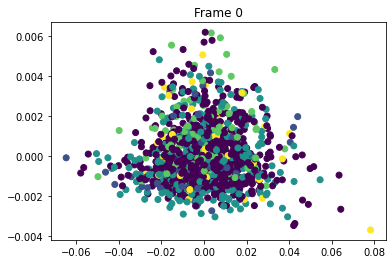

In [51]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#%matplotlib notebook

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Define an update function for the animation
def update(frame):
    ax.clear()
    ax.set_title(f'Frame {frame}')
    
    # Get the PCA result for the current frame
    pca_result = frames[frame]
    
    # Scatter plot of PCA results with color based on index
    scatter = ax.scatter(pca_result[:, 1], pca_result[:, 2], c=label)
    




# Create the animation
ani = FuncAnimation(fig, update, frames=n_frames, repeat=True)

# Display the animation as HTML
HTML(ani.to_jshtml())

In [ ]:
if model.is_variational:
    ani.save('../img/GDS_pca_VAE_0.mp4', writer='ffmpeg')
else:
    ani.save('../img/GDS_pca_AE_0.mp4', writer='ffmpeg')


In [ ]:
torch.save(model, "../workfiles/torch_VAE")

In [7]:
checkpoint_filepath = '../workfiles/simple_autoencoer_model/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [8]:
hist = vae_model.fit(x_train, epochs = 20, callbacks = cb) 

Epoch 1/20


2023-09-07 16:36:10.549505: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


70/70 [==============================] - 10s 117ms/step - loss: 23.1851 - reconstruction_loss: 0.0438 - kl_loss: 8.9281 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 9s 123ms/step - loss: 0.1134 - reconstruction_loss: 0.0197 - kl_loss: 0.0357 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 7s 98ms/step - loss: 0.0182 - reconstruction_loss: 0.0172 - kl_loss: 9.7808e-05 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 8s 113ms/step - loss: 0.0162 - reconstruction_loss: 0.0157 - kl_loss: 7.8253e-05 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 7s 101ms/step - loss: 0.0152 - reconstruction_loss: 0.0150 - kl_loss: 7.7537e-05 - lr: 0.0010
Epoch 6/20
70/70 [==============================] - 8s 115ms/step - loss: 0.0147 - reconstruction_loss: 0.0144 - kl_loss: 7.6753e-05 - lr: 0.0010
Epoch 7/20
70/70 [==============================] - 8s 108ms/step - loss: 0.0145 - reconstruction_loss: 0.0143 - kl_loss: 7.6021e-05 - lr: 0.0

benchmarking model : FC_vae
number of parametters of the model: 13596416
shape of the dataset: (4445, 5977)
the dataset meets the min_max requirement
loss: 0.0137181785
adding new performer to the history


model_name  param_count      loss  obs_count  gene_number
0  FC_autoencoder     13522496  0.002833        NaN          NaN
1  FC_autoencoder     13522496  0.002833        NaN          NaN
2  FC_autoencoder     13522496  0.002833        NaN          NaN
3  FC_autoencoder     13522496  0.002826        NaN          NaN
4  FC_autoencoder     13522496  0.002810        NaN          NaN
5  FC_autoencoder     13522496  0.002810        NaN          NaN
6  FC_autoencoder     13522496  0.002810        NaN          NaN
7  FC_autoencoder     13522496  0.002810     5953.0       5953.0
8  FC_autoencoder     13522496  0.002810     2853.0       5953.0
9  FC_autoencoder     13522496  0.008133     2853.0       5953.0
0          FC_vae     13596416  0.013718     4445.0       5977.0

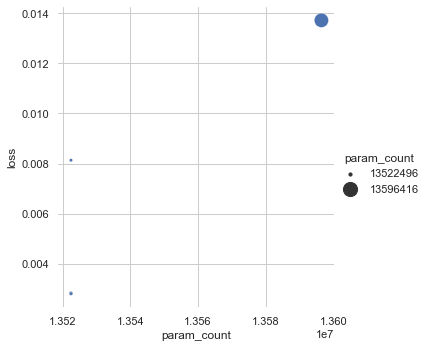

In [18]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(vae_model, x_train)

#### Monitoring training results

In [20]:
vae_model.load_weights(checkpoint_filepath)


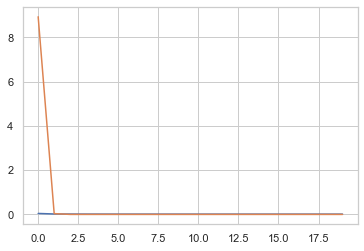

In [21]:
plt.plot(hist.history['reconstruction_loss'][0:])
plt.plot(hist.history['kl_loss'][0:])

# Visu

In [24]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, vae_model)

In [41]:
vae_model.encoder.save('../workfiles/vae_model')

INFO:tensorflow:Assets written to: ../workfiles/vae_model/assets


INFO:tensorflow:Assets written to: ../workfiles/vae_model/assets


### encoding the whole dataset

In [42]:
_, __, compressed_dataframe = vae_model.encoder.predict(x_train)


23/23 [==============================] - 0s 7ms/step


In [43]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [44]:
df.to_csv("../workfiles/processed_data_vae.csv", index=False)


# A bit of post training viz

139/139 [==============================] - 1s 4ms/step


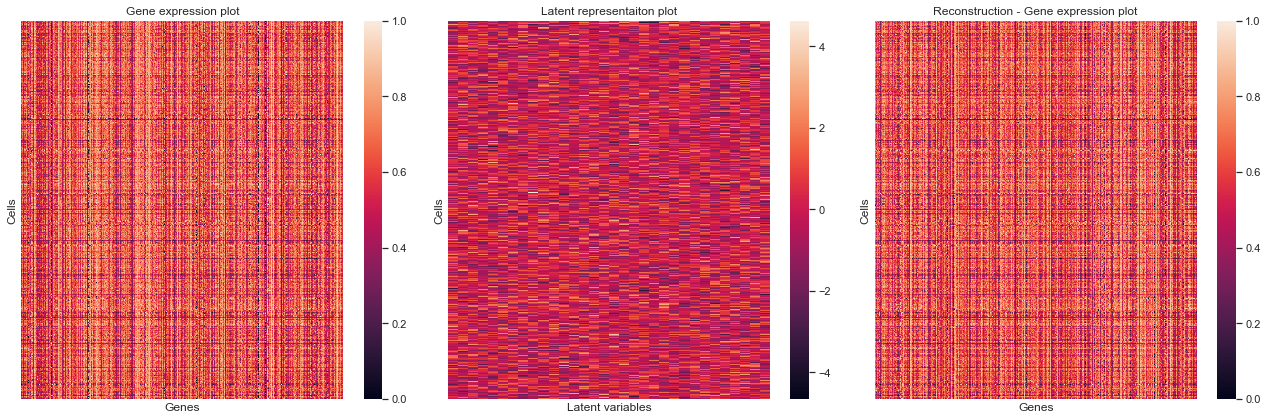

In [25]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, vae_model)
